In [1]:
import glob, os, sys; sys.path.append('../src')
from datetime import datetime

from langdetect import detect
from tabulate import tabulate 
# data wrangling
import numpy as np
import pandas as pd
import re
import ast
import itertools
import wordninja
from dateutil import parser
import wordninja
import string
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
tqdm.pandas()

'''import helper functions'''
import clean as clean
import extract_attributes as ex

'''multiprocessing'''
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 11 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [2]:
# let's load the data
df = pd.read_csv("../data/undp_jobs.csv") 
df.shape

(98894, 2)

In [3]:
# let's transform the columns into Types we can work with: Job_id = INT, content = str. Let's also remove NAN values
df['content'] = df['content'].fillna('').astype(str)
df.shape

(98894, 2)

In [4]:
# let's check the content column so we understand how to properly clean and process it
length_stats = df['content'].str.len().describe(percentiles=[.05, .25, .5, .75, .95])
print(length_stats.round(0))

count    98894.0
mean     10068.0
std       4949.0
min        955.0
5%        3853.0
25%       6740.0
50%       9338.0
75%      12455.0
95%      18768.0
max      75157.0
Name: content, dtype: float64


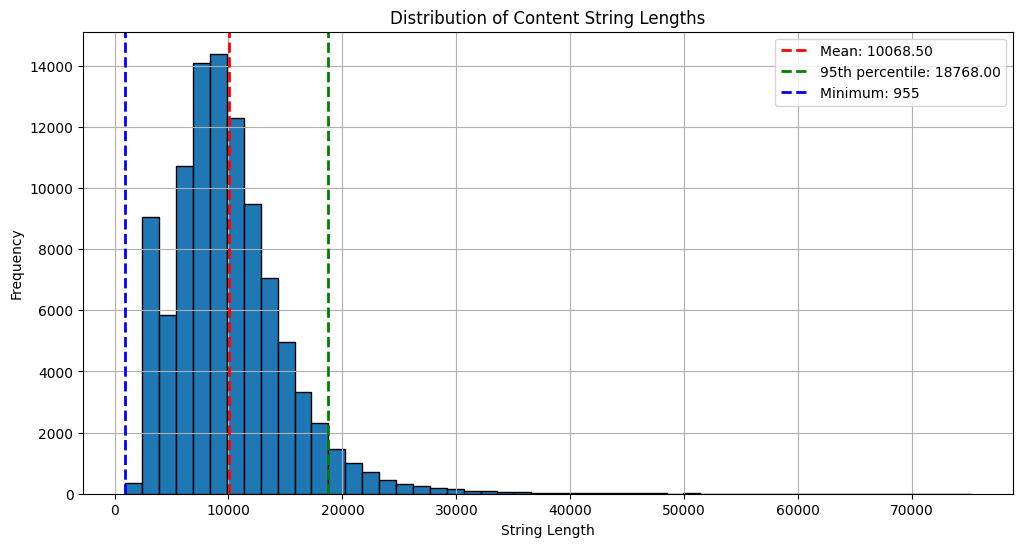

In [5]:
lengths = df['content'].str.len()

plt.figure(figsize=(12, 6))
lengths.hist(bins=50, edgecolor='black')
plt.axvline(lengths.mean(), color='r', linestyle='dashed', linewidth=2, label=f'Mean: {lengths.mean():.2f}')
plt.axvline(lengths.quantile(0.95), color='g', linestyle='dashed', linewidth=2, label=f'95th percentile: {lengths.quantile(0.95):.2f}')
plt.axvline(lengths.min(), color='b', linestyle='dashed', linewidth=2, label=f'Minimum: {lengths.min()}')

plt.title('Distribution of Content String Lengths')
plt.xlabel('String Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [6]:
# let's check the jobs in the 95% percentile to understand why they are so much longer than the rest:
# Calculate the 95th percentile of content length
percentile_95 = df['content'].str.len().quantile(0.95)

# Filter the DataFrame to get rows with content length >= 95th percentile
long_content_df = df[df['content'].str.len() >= percentile_95]

# Sort the result by content length in descending order
long_content_df = long_content_df.sort_values(by='content', key=lambda x: x.str.len(), ascending=False)

# Display the results
print(f"Rows with content length at or above the 95th percentile (length >= {percentile_95:.2f}):")
# for _, row in long_content_df.iterrows():
#     print(f"Job ID: {row['job_id']}")
#     print(f"Content length: {len(row['content'])}")
#     print(f"Content: {row['content'][:100]}...")  # Display first 100 characters
#     print("-" * 50)  # Separator for readability

# Optionally, you can also get the count of such rows
print(f"\nTotal number of rows at or above 95th percentile: {len(long_content_df)}")

Rows with content length at or above the 95th percentile (length >= 18768.00):

Total number of rows at or above 95th percentile: 4947


In [7]:
# let's look at some of them and open in the browser
long_content_df['url'] = "https://jobs.undp.org/cj_view_job.cfm?cur_job_id=" + long_content_df['job_id'].astype(str)
long_content_df.url.iloc[3]

'https://jobs.undp.org/cj_view_job.cfm?cur_job_id=80723'

Ok first take away: We see that the very long jobs usually have some sort of Annex attached to them which mostly includes information that is not really relevant to analyze the jobs and compare them with each other. Let's remember to somehow handle that later.
* We can check later what kind of jobs are so lengthy - probably consultancies that contain condition for consultans 

When we check for the shortest, we see that some job ads are simply Tests or Faulty uploads. We also need to handle these.
* We need to write a script - after we created proper fields - that checks for content. If there is no job description for example - we may remove.

In [8]:
# Create a boolean mask for rows where content length is less than 100
mask = df['content'].str.len() < 1000
# Apply the mask to get a new DataFrame with only the matching rows
filtered_df = df[mask]
# Display the results
print(filtered_df)

       job_id                                            content
83981   16062  ['\n\n\n\n\n\nhome\ntest\n\n\n\ntest\n\n\n\n\n...
94370    5673  ['\n\n\n\n\n\nhome\nlead viii\n\n\n\nlead viii...
98010    2033  ['\n\n\n\n\n\nhome\nlead vii\n\n\n\nlead vii\n...


In [9]:
# Let's check whether a column has valid content (content should be at least 1000 characters by quick testing)
count = 0
for index, row in df.iterrows():
    if len(row['content']) <=1000:
        count = count +1
        print(f"Job ID: {row['job_id']}, Content: {row['content']}")
print(count)

Job ID: 16062, Content: ['\n\n\n\n\n\nhome\ntest\n\n\n\ntest\n\n\n\n\n\n\n\nlocation :\ntest, republic of north macedonia\n\n\ntype of contract :\nother\n\n\nstarting date :\n\n\n\napplication deadline :\n13-apr-10 (midnight new york, usa)\n\n\npost level :\nother\n\n\nduration of initial contract :\n\n\n\nlanguages required :\n \n\n\nexpected duration of assignment :\n\n\n\n\nundp is committed to achieving workforce diversity in terms of gender, nationality and culture. individuals from minority groups, indigenous groups and persons with disabilities are equally encouraged to apply. all applications  will be  treated with the strictest confidence. undp does not tolerate sexual exploitation and abuse, any kind of harassment, including sexual harassment, and discrimination. all selected candidates will, therefore, undergo rigorous reference and background checks.\r\n    \n\n\n\nbackground test \nduties and responsibilities rerw\xa0 test \ncompetencies dsafsa \nrequired skills and experi

In [10]:
# delete NaN rows
df = df[df['content']!="nan"]
df.shape

(98894, 2)

In [11]:
#force column to type list
df['content_list'] = df['content'].parallel_apply(lambda l: ast.literal_eval(l))

In [12]:
# #force column to type list
# import ast

# def safe_eval(x):
#     try:
#         return ast.literal_eval(x)
#     except (ValueError, SyntaxError):
#         # If literal_eval fails, return the original string as a single-item list
#         return [x]

# # Apply the function to create the new column
# df['content_list'] = df['content'].apply(safe_eval)

In [13]:
df.head(3)

,job_id,content,content_list
0,100043,['\n\n\n\n\n\nhome\ninternational consultant-p...,[\n\n\n\n\n\nhome\ninternational consultant-pr...
1,100042,"[""\n\n\n\n\n\nhome\nlocal budget expert (socia...",[\n\n\n\n\n\nhome\nlocal budget expert (social...
2,100041,['\n\n\n\n\n\nhome\ndisability sensitive basel...,[\n\n\n\n\n\nhome\ndisability sensitive baseli...


In [14]:
# Remove special characters, line separation, URLs and enumerations
df['content_list'] = df['content_list'].parallel_apply(lambda l: clean.clean_list(l))

In [15]:
# transform list to str ... try it out
df['content_list'] = df['content_list'].astype(str)

In [16]:
# Binary column whether or not a posting follows the structure (background, competencies, sills and experiences, ...)
template_structure = ['background',
                      'duties and responsibilities',
                      'competencies',
                      'required skills and experience']
for section in template_structure:
    df['has_' + section.replace(' ','_')] = df['content_list'].parallel_apply(lambda l: ex.has_attribute(l, section))

In [17]:
# Assess number of job postings not following the given structure
df[(df['has_background']==0)|\
           (df['has_duties_and_responsibilities']==0)|\
           (df['has_competencies']==0)|\
           (df['has_required_skills_and_experience']==0)]['content'].shape

(6901,)

In [18]:
# Remove job postings not following the given structure and corresponding binary columns
df = df[(df['has_background']!=0)&\
           (df['has_duties_and_responsibilities']!=0)&\
           (df['has_competencies']!=0)&\
           (df['has_required_skills_and_experience']!=0)]

df.drop(['has_background',\
                  'has_duties_and_responsibilities',\
                  'has_competencies',\
                  'has_required_skills_and_experience'], axis=1, inplace=True)

print('Rows following job posting template structure: ', df.shape[0])

Rows following job posting template structure:  91993


In [19]:
# Extract string list of meta attributes such as application deadline, job title, ...
df['meta_atributes'] = df['content_list'].parallel_apply(lambda l: ex.get_meta_attributes(l))

# Extract job posting components following given template
df['background'] = df['content_list'].parallel_apply(lambda l: ex.get_background(l))
df['duties_and_responsibilities'] = df['content_list'].parallel_apply(lambda l: ex.get_duties_and_responsibilities(l))
df['competencies'] = df['content_list'].parallel_apply(lambda l: ex.get_competencies(l))
df['required_skills_and_experience'] = df['content_list'].parallel_apply(lambda l: ex.get_required_skills(l))

In [20]:
df.head(10)

,job_id,content,content_list,meta_atributes,background,duties_and_responsibilities,competencies,required_skills_and_experience
0,100043,['\n\n\n\n\n\nhome\ninternational consultant-p...,['home international consultant-provide techni...,"[[, ', h, o, m, e, , i, n, t, e, r, n, a, t, ...",background checks. background gender ...,u t i e s a n d r e s p o n s i b i l i t ...,o m p e t e n c i e s c o m p l i a n c e ...,e q u i r e d s k i l l s a n d e x p e ...
1,100042,"[""\n\n\n\n\n\nhome\nlocal budget expert (socia...","[""home local budget expert (social protection)...","[[, "", h, o, m, e, , l, o, c, a, l, , b, u, ...",background checks. background host ag...,u t i e s a n d r e s p o n s i b i l i t ...,o m p e t e n c i e s p r o f e s s i o n a ...,e q u i r e d s k i l l s a n d e x p e ...
2,100041,['\n\n\n\n\n\nhome\ndisability sensitive basel...,['home disability sensitive baseline survey co...,"[[, ', h, o, m, e, , d, i, s, a, b, i, l, i, ...",background checks. background the pub...,u t i e s a n d r e s p o n s i b i l i t ...,o m p e t e n c i e s c o r p o r a t e c ...,e q u i r e d s k i l l s a n d e x p e ...
3,100040,"[""\n\n\n\n\n\nhome\nlocal budget expert (parti...","[""home local budget expert (participation) ...","[[, "", h, o, m, e, , l, o, c, a, l, , b, u, ...",background checks. background host ag...,u t i e s a n d r e s p o n s i b i l i t ...,o m p e t e n c i e s p r o f e s s i o n a ...,e q u i r e d s k i l l s a n d e x p e ...
4,100039,"[""\n\n\n\n\n\nhome\ninternational consultant t...","[""home international consultant to conduct a s...","[[, "", h, o, m, e, , i, n, t, e, r, n, a, t, ...",background checks. background un wome...,u t i e s a n d r e s p o n s i b i l i t ...,o m p e t e n c i e s c o r e v a l u e s ...,e q u i r e d s k i l l s a n d e x p e ...
5,100038,"[""\n\n\n\n\n\nhome\nnational consultant to con...","[""home national consultant to conduct a study ...","[[, "", h, o, m, e, , n, a, t, i, o, n, a, l, ...",background checks. background un wome...,u t i e s a n d r e s p o n s i b i l i t ...,o m p e t e n c i e s c o r e v a l u e s ...,e q u i r e d s k i l l s a n d e x p e ...
6,100037,['\n\n\n\n\n\nhome\nconsultoría ssa nacional -...,['home consultoría ssa nacional - asistencia t...,"[[, ', h, o, m, e, , c, o, n, s, u, l, t, o, ...",background checks. background la enti...,u t i e s a n d r e s p o n s i b i l i t ...,o m p e t e n c i e s c o m p e t e n c i a ...,e q u i r e d s k i l l s a n d e x p e ...
7,100036,['\n\n\n\n\n\nhome\nconsultoria ssa nacional -...,['home consultoria ssa nacional - elaboración ...,"[[, ', h, o, m, e, , c, o, n, s, u, l, t, o, ...",background checks. background la enti...,u t i e s a n d r e s p o n s i b i l i t ...,o m p e t e n c i e s c o m p e t e n c i a ...,e q u i r e d s k i l l s a n d e x p e ...
8,100035,['\n\n\n\n\n\nhome\ncommunications coordinator...,['home communications coordinator communica...,"[[, ', h, o, m, e, , c, o, m, m, u, n, i, c, ...",background checks. background instruc...,u t i e s a n d r e s p o n s i b i l i t ...,o m p e t e n c i e s p r o f e s s i o n a ...,e q u i r e d s k i l l s a n d e x p e ...
9,100034,['\n\n\n\n\n\nhome\nunv experto - salud y migr...,['home unv experto - salud y migración unv ...,"[[, ', h, o, m, e, , u, n, v, , e, x, p, e, ...",background checks. background de acue...,u t i e s a n d r e s p o n s i b i l i t ...,o m p e t e n c i e s p r o f e s i o n a l ...,e q u i r e d s k i l l s a n d e x p e ...


In [21]:
import re
meta_attributes = ['location', 'application deadline', 'time left', 'additional category',\
                  'type of contract','post level','languages required','starting date',\
                   'duration of initial contract','expected duration of assignment']

# Extract meta attributes in seperate columns
df['title'] = df['meta_atributes'].apply(lambda l: l[0])
for m_attr in meta_attributes:
    df[m_attr.replace(' ', '_')] = df['meta_atributes'].parallel_apply(lambda l: ex.extract_meta_attribute(m_attr,l))

In [24]:
# Consolidate column names with names from UNDP previous work
df.rename(columns={'duration_of_initial_contract':'duration_contract',\
                            'expected_duration_of_assignment':'duration_assignment',\
                            'required_skills_and_experience':'skills_experiences',\
                            'duties_and_responsibilities':'duties_responsibilities'}, inplace=True)

In [28]:
df.head(10)

,job_id,content,content_list,meta_atributes,background,duties_responsibilities,competencies,skills_experiences,title,location,application_deadline,time_left,additional_category,type_of_contract,post_level,languages_required,starting_date,duration_contract,duration_assignment
0,100043,['\n\n\n\n\n\nhome\ninternational consultant-p...,['home international consultant-provide techni...,"[[, ', h, o, m, e, , i, n, t, e, r, n, a, t, ...",background checks. background gender ...,u t i e s a n d r e s p o n s i b i l i t ...,o m p e t e n c i e s c o m p l i a n c e ...,e q u i r e d s k i l l s a n d e x p e ...,[,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100042,"[""\n\n\n\n\n\nhome\nlocal budget expert (socia...","[""home local budget expert (social protection)...","[[, "", h, o, m, e, , l, o, c, a, l, , b, u, ...",background checks. background host ag...,u t i e s a n d r e s p o n s i b i l i t ...,o m p e t e n c i e s p r o f e s s i o n a ...,e q u i r e d s k i l l s a n d e x p e ...,[,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100041,['\n\n\n\n\n\nhome\ndisability sensitive basel...,['home disability sensitive baseline survey co...,"[[, ', h, o, m, e, , d, i, s, a, b, i, l, i, ...",background checks. background the pub...,u t i e s a n d r e s p o n s i b i l i t ...,o m p e t e n c i e s c o r p o r a t e c ...,e q u i r e d s k i l l s a n d e x p e ...,[,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100040,"[""\n\n\n\n\n\nhome\nlocal budget expert (parti...","[""home local budget expert (participation) ...","[[, "", h, o, m, e, , l, o, c, a, l, , b, u, ...",background checks. background host ag...,u t i e s a n d r e s p o n s i b i l i t ...,o m p e t e n c i e s p r o f e s s i o n a ...,e q u i r e d s k i l l s a n d e x p e ...,[,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100039,"[""\n\n\n\n\n\nhome\ninternational consultant t...","[""home international consultant to conduct a s...","[[, "", h, o, m, e, , i, n, t, e, r, n, a, t, ...",background checks. background un wome...,u t i e s a n d r e s p o n s i b i l i t ...,o m p e t e n c i e s c o r e v a l u e s ...,e q u i r e d s k i l l s a n d e x p e ...,[,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,100038,"[""\n\n\n\n\n\nhome\nnational consultant to con...","[""home national consultant to conduct a study ...","[[, "", h, o, m, e, , n, a, t, i, o, n, a, l, ...",background checks. background un wome...,u t i e s a n d r e s p o n s i b i l i t ...,o m p e t e n c i e s c o r e v a l u e s ...,e q u i r e d s k i l l s a n d e x p e ...,[,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,100037,['\n\n\n\n\n\nhome\nconsultoría ssa nacional -...,['home consultoría ssa nacional - asistencia t...,"[[, ', h, o, m, e, , c, o, n, s, u, l, t, o, ...",background checks. background la enti...,u t i e s a n d r e s p o n s i b i l i t ...,o m p e t e n c i e s c o m p e t e n c i a ...,e q u i r e d s k i l l s a n d e x p e ...,[,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,100036,['\n\n\n\n\n\nhome\nconsultoria ssa nacional -...,['home consultoria ssa nacional - elaboración ...,"[[, ', h, o, m, e, , c, o, n, s, u, l, t, o, ...",background checks. background la enti...,u t i e s a n d r e s p o n s i b i l i t ...,o m p e t e n c i e s c o m p e t e n c i a ...,e q u i r e d s k i l l s a n d e x p e ...,[,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,100035,['\n\n\n\n\n\nhome\ncommunications coordinator...,['home communications coordinator communica...,"[[, ', h, o, m, e, , c, o, m, m, u, n, i, c, ...",background checks. background instruc...,u t i e s a n d r e s p o n s i b i l i t ...,o m p e t e n c i e s p r o f e s s i o n a ...,e q u i r e d s k i l l s a n d e x p e ...,[,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,100034,['\n\n\n\n\n\nhome\nunv experto - salud y migr...,['home unv experto - salud y migración unv ...,"[[, ', h, o, m, e, , u, n, v, , e, x, p, e, ...",background checks. background de acue...,u t i e s a n d r e s p o n s i b i l i t ...,o m p e t e n c i e s p r o f e s i o n 

In [27]:
# parse dates
df['application_deadline'] = df['application_deadline'].apply(lambda s: parser.parse(str(s)[:9]))

ParserError: Unknown string format: nan

In [ ]:
df.head(10)

In [ ]:
# extract year from date
df['year'] = df['application_deadline'].apply(lambda l: str(l.year))

In [ ]:
columns = ['content','title','location','year','time_left','additional_category','type_of_contract','post_level','languages_required','starting_date','duration_contract','duration_assignment',\
           'background','duties_responsibilities','competencies','skills_experiences']

df_jobs = df[columns]

In [ ]:
# dropping vacancies with missing data in key columns
print(f'Shape before: {df_jobs.shape}')

df_jobs.dropna(subset = ['title', 'location', 'year', 'background'], how = 'any', inplace = True)
print(f'Shape after : {df_jobs.shape}')

# dropping duplicated vacancies
to_keep = ['title', 'location', 'year', 'background', 'duties_responsibilities']
df_jobs.drop_duplicates(subset = to_keep, inplace = True)
print(f'Shape after : {df_jobs.shape}')

# generating unique vacancy ids
df_jobs.insert(0, 'job_id', df_jobs[to_keep].fillna('').apply(lambda x: ' '.join(list(x)), axis = 1))
df_jobs['job_id'] = df_jobs['job_id'].apply(lambda x: clean.generate_key(x, prefix = 'JOB'))
assert df_jobs.duplicated(subset = ['job_id']).sum() == 0, 'Non-unique id'
print(f'Shape after : {df_jobs.shape}')

# percentage not missing
display(df_jobs.notna().sum().divide(len(df_jobs) / 100).round(2).astype(str).add('%'))

# Further Cleaning and Processing

In [ ]:
# detect language 
df_jobs['language'] = [extract_language(x) for x in tqdm(df_jobs['background'])]

Now we should translate the non-english postings....

In [ ]:
# Detect and split joint words  (legacy from raw data extraction), the library used here is only defined for the English language
for field in ['background', 'duties_responsibilities', 'competencies', 'skills_experiences']:
    print('Prcessing field: ', field)
    df_jobs[field] = [clean.split_joint_words(x) for x in tqdm(df_jobs[field])]

# Locations

In [ ]:
# dependency file with locations
df_locations = pd.read_excel('../src/world-countries.xlsx', engine='openpyxl')
df_locations['country'] = df_locations['country'].str.lower()
print(f'Shape: {df_locations.shape}')
display(df_locations.head())

country2iso = dict(df_locations[['country', 'country_iso']].values)
country2region = dict(df_locations[['country_iso', 'region']].values)

In [ ]:
print('Unique count before:', df_jobs['location'].nunique())
display(df_jobs['location'].value_counts(dropna = False).head(20))

df_jobs.insert(4, 'country', df_jobs['location'].apply(lambda x: clean.clean_location(x, country2iso)))
print('Unique count after :', df_jobs['country'].nunique())
display(df_jobs['country'].value_counts(dropna = False).head(20))

df_jobs.insert(5, 'region', df_jobs['country'].apply(lambda x: clean.get_region(x, country2region)))
display(df_jobs['region'].value_counts(dropna = False))

In [ ]:
df_jobs['year'].value_counts(dropna = False).sort_index()

In [ ]:
df_jobs = df_jobs.drop('additional_category', 1)

In [ ]:
print('Unique count before:', df_jobs['type_of_contract'].nunique())
display(df_jobs['type_of_contract'].value_counts(dropna = False).head(20))

df_jobs['type_of_contract'] = df_jobs['type_of_contract'].apply(clean.clean_contracts)
print('Unique count after :', df_jobs['type_of_contract'].nunique())
display(df_jobs['type_of_contract'].value_counts(dropna = False))

In [ ]:
df_jobs['post_level'] = df_jobs['post_level'].parallel_apply(clean.clean_posts)
print('Unique count after :', df_jobs['post_level'].nunique())
display(df_jobs['post_level'].value_counts(dropna = False))

In [5]:
mapping = {'D-1': 'International Professional',
           'D-2': 'International Professional',
           'Intern': 'Intern',
           'International Consultant': 'International Consultant',
           'NO-A': 'National Professional',
           'NO-B': 'National Professional',
           'NO-C': 'National Professional',
           'NO-D': 'National Professional',
           'National Consultant': 'National Consultant',
           'P-1': 'International Professional',
           'P-2': 'International Professional',
           'P-3': 'International Professional',
           'P-4': 'International Professional',
           'P-5': 'International Professional',
           'SB/SC/GS-1': 'General Service',
           'SB/SC/GS-2': 'General Service',
           'SB/SC/GS-3': 'General Service',
           'SB/SC/GS-4': 'General Service',
           'SB/SC/GS-5': 'General Service',
           'SB/SC/GS-6': 'General Service',
           'SB/SC/GS-7': 'General Service',
           'SB/SC/GS-8': 'General Service',
           'SB/SC/GS-9': 'General Service',
           'SB/SC/GS-10': 'General Service',
           'SB/SC/GS-11': 'General Service',
           'UNV': 'UNV',
           'IPSA': 'IPSA',
           'NPSA': 'NPSA',
           'Other': 'Other',
           'Unspecified': 'Unspecified'}

In [ ]:
df_jobs.insert(12, 'staff_category', df_jobs['post_level'].replace(mapping).tolist())
display(df_jobs['staff_category'].value_counts(dropna = False))

In [ ]:
df_jobs['languages_required'] = df_jobs['languages_required'].apply(clean.clean_languages)
df_jobs['languages_required'].str.split(' ').explode().value_counts()

In [ ]:
to_drop = ['location', 'time_left', 'starting_date', 'duration_contract', 'duration_assignment']

print(f'Shape before: {df_jobs.shape}')
df_jobs.drop(to_drop, axis = 1, inplace = True)
df_jobs['year'] = df_jobs['year'].astype(int)

print(f'Shape after : {df_jobs.shape}')
display(df_jobs.head())

In [ ]:
df_jobs.to_parquet('../data/undp_jobs_processed.parquet')
print('saved!!!')